#Function

In [1]:
def find_file_in_drive(filename):
    """
    Search for a file with a specific filename in Google Drive directories.

    Args:
    - filename (str): The name of the file to search for.

    Returns:
    - str or None: The full path to the file if found, or None if not found.
    """
    for root, dirs, files in os.walk('/content/drive'):
        if filename in files:
            return os.path.join(root, filename)
    return None


def remove_stop_words(dataframe, target_column_name, new_column_name):
    """
    Remove common English stopwords from a specified column in a DataFrame and create a new column.

    Args:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - target_column_name (str): The name of the column to remove stopwords from.
    - new_column_name (str): The name of the new column to store the cleaned text.

    Returns:
    - pd.DataFrame: The DataFrame with the new column containing text without stopwords.
    """
    dataframe[new_column_name] = dataframe[target_column_name].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords.words('english')]))
    return dataframe


def mask_inputs_for_bert(data, max_len):
    """
    Tokenize text data and create input IDs and attention masks for BERT model.

    Args:
    - data (list): List of text data to tokenize.
    - max_len (int): Maximum sequence length for padding/truncation.

    Returns:
    - tf.Tensor: Tensor containing input IDs.
    - tf.Tensor: Tensor containing attention masks.
    """
    # Tokenize all of the sentences and map the tokens to their word IDs
    input_ids = []
    attention_masks = []

    for sms in data:
        encoded_dict = tokenizer.encode_plus(sms,  # sentence to encode
                                            add_special_tokens=True,  # Add [CLS] and [SEP] tokens at the beginning and end
                                            max_length=max_len,
                                            pad_to_max_length=True,  # Pad and truncate all sentences
                                            return_attention_mask=True)  # Construct attention masks

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)

    return input_ids, attention_masks


def get_most_frequent_words(text):
    """
    Get the most frequent non-numeric words from a given text.

    Args:
    - text (str): The input text.

    Returns:
    - list: A list of the most frequent non-numeric words in the text.
    """
    words = text.split()
    word_counts = Counter(words)
    most_common = word_counts.most_common(3)
    return [word for word, count in most_common if re.match(r"^\D+$", word)]


def expand_abbreviations(text, abbreviations_dict):
    """
    Expand abbreviations in a given text using a dictionary of abbreviations and their expansions.

    Args:
    - text (str): The input text containing abbreviations to be expanded.
    - abbreviations_dict (dict): A dictionary containing abbreviations as keys and their corresponding expansions as values.

    Returns:
    - str: The text with abbreviations expanded.
    """
    for abbrev, expansion in abbreviations_dict.items():
        pattern = re.compile(rf'\b{re.escape(abbrev)}\b', re.IGNORECASE)  # Create a case-insensitive regex pattern for the abbreviation
        text = pattern.sub(expansion, text)  # Substitute the abbreviation with its expansion in the text
    return text



# Import Library and Dataset

In [3]:
!pip install text_preprocessing
!pip install pandas==1.5.3
!pip install contextualized_topic_models
!pip install pyLDAvis==2.1.2
!pip install gensim
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.3/784.3 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.2
    Uninstalling gensim-4.3.2:
      Successfully uninstalled gensim-4.3.2
  Attempting uninstall: ipython
    

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97718 sha256=9d997d34f104fc637352bb24ef00b1dcd96e336fb03eba8c1113a5af451d5685
  Stored in directory: /root/.cache/pip/wheels/d9/93/d6/16c95da19c32f037fd75135ea152d0df37254c25cd1a8b4b6c
Successfully built pyLDAvis


In [4]:
import re
import os
import zipfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from collections import Counter

from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim as gensimvis
from wordcloud import WordCloud

import keras
import tensorflow as tf
from keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
from google.colab import drive

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
drive.mount('/content/drive')
zip_filename = 'SMS Spam dataset.zip'
zip_path = find_file_in_drive(zip_filename)

if zip_path is None:
    print(f'File {zip_filename} not found.')
else:
    print(f'File found: {zip_path}')

if zip_path is not None:
    extract_path = '/content/dataset'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    csv_file = os.path.join(extract_path, 'spam.csv')

    if os.path.isfile(csv_file):
        spam_data = pd.read_csv(csv_file, encoding = "ISO-8859-1", header=0)

        print(spam_data.head())
    else:
        print('File spam.csv not found')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive
File found: /content/drive/MyDrive/SMS Spam dataset.zip
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


# Pre-Processing

In [6]:
spam_data.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
spam_data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
spam_data['text'] = spam_data['text'].map(lambda x: x.lower())
spam_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,target,text
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."
5,1,freemsg hey there darling it's been 3 week's n...
6,0,even my brother is not like to speak with me. ...
7,0,as per your request 'melle melle (oru minnamin...
8,1,winner!! as a valued network customer you have...
9,1,had your mobile 11 months or more? u r entitle...


In [7]:
no_special_char=[]
for sentence in spam_data.text:
    no_special_char.append(re.sub('[^A-Za-z0-9]+', ' ', sentence))
spam_data["text"]=no_special_char


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
spam_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,target,text
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor u c already then say
4,0,nah i don t think he goes to usf he lives arou...
5,1,freemsg hey there darling it s been 3 week s n...
6,0,even my brother is not like to speak with me t...
7,0,as per your request melle melle oru minnaminun...
8,1,winner as a valued network customer you have b...
9,1,had your mobile 11 months or more u r entitled...


In [9]:
spam_data = remove_stop_words(spam_data, 'text', 'text')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
spam_data.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,target
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [11]:
X, y = spam_data['text'], spam_data['target']
X_train, X_test, y_train, y_test = train_test_split(spam_data['text'],
                                                    spam_data['target'],
                                                    random_state=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# KERAS TOKENIZER

In [ ]:
max_feature = 50000
tokenizer = Tokenizer(num_words= max_feature)
tokenizer.fit_on_texts(X_train)
x_train_features = np.array(tokenizer.texts_to_sequences(X_train))
x_test_features = np.array(tokenizer.texts_to_sequences(X_test))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-55-308ab9f7eac5>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train_features = np.array(tokenizer.texts_to_sequences(X_train))
<ipython-input-55-308ab9f7eac5>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' w

In [ ]:
lengths=[]
for sentence in x_train_features:
  lengths.append(len(sentence))
max_len = int(np.quantile(lengths, 0.75))
max_len

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14

In [ ]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#size of the output vector from each layer
embedding_vector_length = 32
#Creating a sequential model
model = tf.keras.Sequential()
#Creating an embedding layer to vectorize
model.add(Embedding(max_feature, embedding_vector_length, input_length=max_len))
#Addding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
#Relu allows converging quickly and allows backpropagation
model.add(Dense(16, activation='relu'))
#Deep Learning models can be overfit easily, to avoid this, we add randomization using drop out
model.add(Dropout(0.1))
#Adding sigmoid activation function to normalize the output
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 32)            1600000   
                                                                 
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1651745 (6.30 MB)
Trainable params: 1651745 (6.30 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
history = model.fit(x_train_features, y_train, batch_size=512, epochs=15, validation_data=(x_test_features, y_test))
y_predict = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9/9 [==============================] - 18s 442ms/step - loss: 0.6820 - accuracy: 0.7102 - val_loss: 0.6386 - val_accuracy: 0.8586
Epoch 2/15
9/9 [==============================] - 5s 544ms/step - loss: 0.5751 - accuracy: 0.8684 - val_loss: 0.4346 - val_accuracy: 0.8586
Epoch 3/15
9/9 [==============================] - 3s 285ms/step - loss: 0.3225 - accuracy: 0.8684 - val_loss: 0.3239 - val_accuracy: 0.8586
Epoch 4/15
9/9 [==============================] - 3s 283ms/step - loss: 0.2137 - accuracy: 0.8684 - val_loss: 0.2014 - val_accuracy: 0.8586
Epoch 5/15
9/9 [==============================] - 1s 153ms/step - loss: 0.1482 - accuracy: 0.8990 - val_loss: 0.1663 - val_accuracy: 0.9497
Epoch 6/15
9/9 [==============================] - 1s 114ms/step - loss: 0.1096 - accuracy: 0.9825 - val_loss: 0.1389 - val_accuracy: 0.9691
Epoch 7/15
9/9 [==============================] - 1s 156ms/step - loss: 0.0720 - accuracy: 0.9899 - val_loss: 0.0856 - val_accuracy: 0.9763
Epoch 8/15
9/9 [==============

In [ ]:
cf_matrix =confusion_matrix(y_test,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test,y_predict)))

Precision: 96.26%
Recall: 91.37%
F1 Score: 93.75%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Spam percentage

In [ ]:
spam_percent = len(spam_data[spam_data['target'] == 1]) / len(spam_data) * 100

print("Spam percentage {:.2f}%".format(spam_percent))

Spam percentage 13.41%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


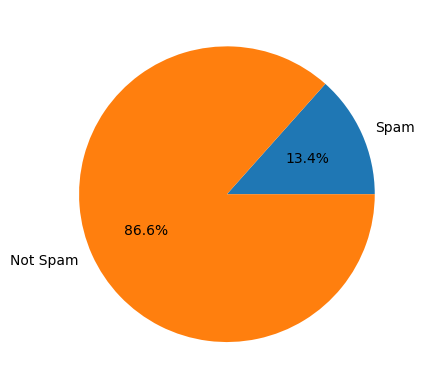

In [ ]:
spam = len(spam_data[spam_data['target'] == 1])
not_spam = len(spam_data[spam_data['target'] == 0])
labels = ['Spam', 'Not Spam']
sizes = [spam, not_spam]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
fig.show()

### Length of sentences

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


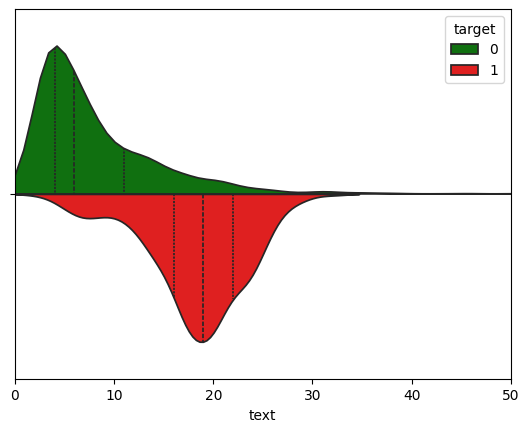

In [ ]:
ax = sns.violinplot(data = spam_data, x = spam_data["text"].map(lambda x: len(x.split())), hue = spam_data["target"], split=True, inner='quart', palette=['green', 'red'])
ax.set(xlim=(0, 50))
plt.show()

# BERT TRANSFER LEARNING

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len = int(np.quantile(X_train.map(lambda x: len(x.split())), 0.75))
print('The maximum length of the textual sequences is: {:.2f}'.format(max_len))

The maximum length of the textual sequences is: 14.00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_inp, train_mask = mask_inputs_for_bert(X_train, max_len)
val_inp, val_mask = mask_inputs_for_bert(X_test, max_len)
train_label = tf.convert_to_tensor(y_train)
val_label = tf.convert_to_tensor(y_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the bat

In [ ]:
print("Train input shape: ", train_inp.shape)
print("Train mask shape: ", train_mask.shape)
print("Validation input shape: ", val_inp.shape)
print("Validation mask shape: ", val_mask.shape)
print("Train label shape: ", train_label.shape)
print("Validation label shape: ", val_label.shape)

Train input shape:  (4179, 14)
Train mask shape:  (4179, 14)
Validation input shape:  (1393, 14)
Validation mask shape:  (1393, 14)
Train label shape:  (4179,)
Validation label shape:  (1393,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_38 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
history = bert_model.fit([train_inp, train_mask],
                         train_label,
                         batch_size=32,
                         epochs=4,
                         validation_data=([val_inp, val_mask], val_label))

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


131/131 [==============================] - 75s 207ms/step - loss: 2.2829 - accuracy: 0.8143 - val_loss: 2.1814 - val_accuracy: 0.8586
Epoch 2/4
131/131 [==============================] - 19s 145ms/step - loss: 2.0301 - accuracy: 0.8684 - val_loss: 2.1814 - val_accuracy: 0.8586
Epoch 3/4
131/131 [==============================] - 19s 146ms/step - loss: 2.0301 - accuracy: 0.8684 - val_loss: 2.1814 - val_accuracy: 0.8586
Epoch 4/4
131/131 [==============================] - 19s 145ms/step - loss: 2.0301 - accuracy: 0.8684 - val_loss: 2.1814 - val_accuracy: 0.8586


The pretrained *'bert-base-uncased'* model achieves an accuracy of 86%.

While it is still a good performance, it is remarkably lower than the custom neural network I had developed earlier. This is because the weights have been pretrained on other data with different embedding vectors and for a different purpose, consequently the model is not capable of catching the informative patterns as much.

### Word cloud of spam SMS

In [ ]:
prova = spam_data[spam_data['target']==1]['text']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_words = prova.map(lambda x: get_most_frequent_words(x)).explode()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_words.dropna(inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_words = ' '.join(list(frequent_words))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_words

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'entry fa free freemsg hey darling claim winner valued mobile update free six chances win urgent week xxxmobilemovieclub click wap england team charged thanks subscription call free sptv end sms congrats year valued customer pleased urgent ur awarded hear new divorce please call customer free ringtone waiting gent trying contact winner u private account urgent mobile awarded todays voda numbers sunshine quiz wkly want dogging u rcv msgs freemsg replied text delivery customer service winner u stop bootydelious ur u service urgent trying contact please call customer unique enough find new mobiles ur horo u text meet u secret congratulations ur awarded reply tried contact text hey stop ur ringtone ringtone club get hmv bonus special mobile customer may sms ac blind themob check newest week think ur mobile update free call access valentines day special fancy shag interested congratulations ur awarded cash ur balance update xmas offer stop discount code thanks ringtone order double mins txt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


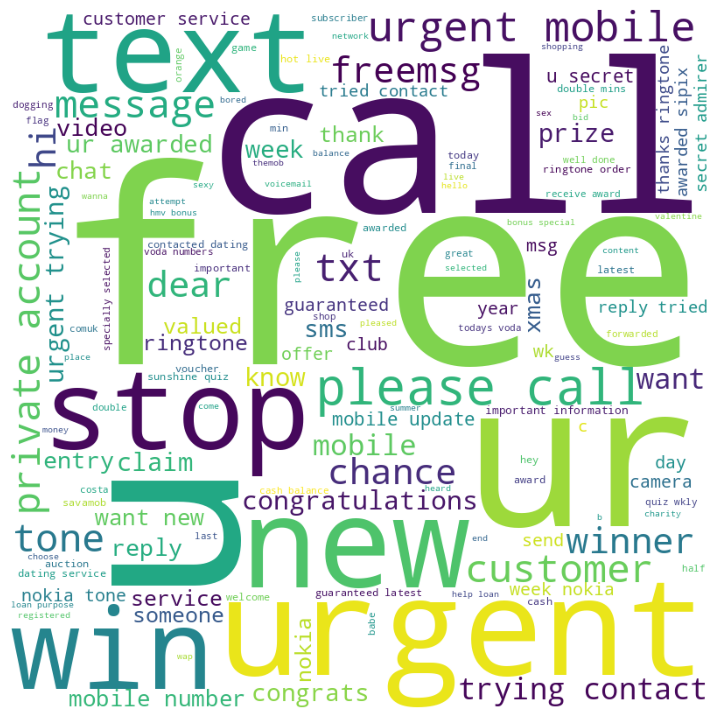

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(frequent_words)

plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# TOPIC MODELING

In [12]:
spam_data=spam_data['text']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
abbreviations = {
    "u": "you",
    "ur": "your",
    "lol": "laughing out loud",
    "brb": "be right back",
    "btw": "by the way",
    "idk": "I do not know",
    "imo": "in my opinion",
    "omg": "oh my god",
    "thx": "thanks",
    "ttyl": "talk to you later",
    "nvm": "never mind",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "afaik": "as far as I know",
    "fwiw": "for what it’s worth",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "wtf": "what the fuck",
    "bff": "best friends forever",
    "jk": "just kidding",
    "np": "no problem",
    "plz": "please",
    "ty": "thank you",
    "gr8": "great",
    "b4": "before",
    "dat": "that",
    "dunno": "do not know",
    "gonna": "going to",
    "wanna": "want to",
    "luv": "love",
    "msg": "message",
    "txt": "text",
    "k": "okay",
    "r": "are",
    "y": "why",
    "b": "be",
    "c": "see",
    "u2": "you too",
    "2": "to",
    "4": "for",
    "bcoz": "because",
    "tho": "though",
    "thru": "through",
    "ppl": "people",
    "sry": "sorry",
    "grl": "girl",
    "boi": "boy",
    "m8": "mate",
    "hm": "home",
    "tmrw": "tomorrow",
    "nite": "night",
    "tonite": "tonight",
    "cu": "see you",
    "asap": "as soon as possible",
    "f2f": "face to face",
    "bday": "birthday",
    "xoxo": "hugs and kisses",
    "ez": "easy",
    "fml": "fuck my life",
    "gg": "good game",
    "bruh": "brother",
    "bro": "brother",
    "sis": "sister",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "ily": "I love you",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "stfu": "shut the fuck up",
    "tyt": "take your time",
    "ttyl": "talk to you later",
    "yw": "you're welcome",
    "tbh": "to be honest",
    "tbf": "to be fair",
    "rn": "right now",
    "afaik": "as far as I know",
    "idc": "I don't care",
    "idgaf": "I don't give a fuck",
    "idk": "I don't know",
    "iirc": "if I recall correctly",
    "ikr": "I know, right?",
    "ily": "I love you",
    "imho": "in my humble opinion",
    "imo": "in my opinion",
    "irl": "in real life",
    "jfc": "Jesus fucking Christ",
    "jfyi": "just for your information",
    "lmao": "laugh my ass off",
    "lmfao": "laughing my fucking ass off",
    "lol": "laugh out loud",
    "nbd": "no big deal",
    "nfs": "not for sale",
    "ngl": "not gonna lie",
    "nm": "not much",
    "nvm": "never mind",
    "omg": "oh my God",
    "oml": "oh my Lord",
    "omw": "on my way",
    "ppl": "people",
    "rofl": "rolling on the floor laughing",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "tbr": "to be real",
    "tbt": "throwback Thursday",
    "tfw": "that feeling when",
    "tho": "though",
    "til": "today I learned",
    "tmi": "too much information",
    "ttyl": "talk to you later",
    "ty": "thank you",
    "tyvm": "thank you very much",
    "wb": "welcome back",
    "wtf": "what the fuck",
    "wtg": "way to go",
    "wth": "what the hell",
    "wym": "what you mean",
    "wyd": "what you doing",
    "wys": "what you saying",
    "wyw": "what you want",
    "yolo": "you only live once",
    "yw": "you're welcome"
}


# Apply the abbreviation expansion function to all documents
expanded_documents = [expand_abbreviations(doc, abbreviations) for doc in spam_data]

# Print the expanded documents
for i, (original, expanded) in enumerate(zip(spam_data, expanded_documents), 1):
    print(f"Document {i} (original): {original}")
    print(f"Document {i} (expanded): {expanded}\n")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
Document 3906 (expanded): went fast asleep dear take care

Document 3907 (original): means fat head
Document 3907 (expanded): means fat head

Document 3908 (original): sounds like plan cardiff still still cold sitting radiator
Document 3908 (expanded): sounds like plan cardiff still still cold sitting radiator

Document 3909 (original): serious like proper tongued
Document 3909 (expanded): serious like proper tongued

Document 3910 (original): good wondering wont say hi smiling coping long distance
Document 3910 (expanded): good wondering wont say hi smiling coping long distance

Document 3911 (original): noe da car later c lar wearing shorts
Document 3911 (expanded): noe da car later see lar wearing shorts

Document 3912 (original): important customer service announcement call freephone 0800 542 0825
Document 3912 (expanded): important customer service announcement call freephone 0800 542 0825

Document 3913 (original): yeah whatever 

In [ ]:
# Split and preprocess documents
split_preprocessed_documents = [d.split() for d in expanded_documents if d.strip()]

# Create a Dictionary for the corpus
dictionary = Dictionary(split_preprocessed_documents)

# Filter extremes in the dictionary
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Create a Bag of Words (BoW) representation of the corpus
corpus = [dictionary.doc2bow(text) for text in split_preprocessed_documents]

# Initialize variables to track the best model
best_topic_coherence = -999
best_num_topics = 0
best_model = None

# Define a list of candidate numbers of topics
num_topics = list(range(2, 21))

# Number of runs for each number of topics
num_runs = 3

# List to store coherence and perplexity scores
a = []

# Loop through each candidate number of topics and run multiple times
for n_components in num_topics:
    for i in range(num_runs):
        print("Number of topics:", n_components)

        # Train an LDA model
        lda = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=n_components,
            iterations=1000,
            passes=20,
            random_state=42
        )

        # Calculate the coherence score
        coherence_model_lda = CoherenceModel(
            model=lda,
            texts=split_preprocessed_documents,
            dictionary=dictionary,
            coherence='c_v'
        )

        coh_score = coherence_model_lda.get_coherence()
        print("Coherence score:", coh_score)

        # Calculate perplexity
        perplexity = lda.log_perplexity(corpus)
        print("Perplexity score:", perplexity)

        # Append coherence and perplexity scores to the list
        a.append((coh_score, perplexity))

        # Update the best model if the coherence score is higher
        if best_topic_coherence < coh_score:
            best_topic_coherence = coh_score
            best_num_topics = n_components
            best_model = lda
            best_model_perplexity = perplexity

        print("Current best coherence:", best_topic_coherence, "/ best number of topics:", best_num_topics)

# Print the final results
print("Best number of topics:", best_num_topics)
print("Best coherence score:", best_topic_coherence)
print("Best perplexity score:", best_model_perplexity)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of topics: 2
Coherence score: 0.36159527657647417
Perplexity score: -5.790510620074585
Current best coherence: 0.36159527657647417 / best number of topics: 2
Number of topics: 2
Coherence score: 0.36159527657647417
Perplexity score: -5.790382040323262
Current best coherence: 0.36159527657647417 / best number of topics: 2
Number of topics: 2
Coherence score: 0.36159527657647417
Perplexity score: -5.789900773940964
Current best coherence: 0.36159527657647417 / best number of topics: 2
Number of topics: 3
Coherence score: 0.44032005236513266
Perplexity score: -5.735606388779985
Current best coherence: 0.44032005236513266 / best number of topics: 3
Number of topics: 3
Coherence score: 0.43528027073435277
Perplexity score: -5.736193870250583
Current best coherence: 0.44032005236513266 / best number of topics: 3
Number of topics: 3
Coherence score: 0.44032005236513266
Perplexity score: -5.736445517715582
Current best coherence: 0.44032005236513266 / best number of topics: 3
Number of 

In [ ]:
# Print the Keyword in the 10 topics
for topic_id, topic_keywords in best_model.print_topics(num_topics=4):
    print(f"Topic {topic_id} Keywords: {topic_keywords}")


Topic 0 Keywords: 0.062*"call" + 0.054*"gt" + 0.054*"lt" + 0.028*"sorry" + 0.021*"ok" + 0.019*"dear" + 0.017*"please" + 0.016*"later" + 0.016*"prize" + 0.016*"laugh"
Topic 1 Keywords: 0.115*"you" + 0.047*"to" + 0.023*"go" + 0.021*"come" + 0.021*"going" + 0.020*"for" + 0.020*"want" + 0.019*"ok" + 0.019*"home" + 0.018*"lor"
Topic 2 Keywords: 0.049*"text" + 0.038*"free" + 0.033*"your" + 0.030*"call" + 0.026*"send" + 0.024*"message" + 0.023*"to" + 0.023*"1" + 0.022*"stop" + 0.020*"reply"
Topic 3 Keywords: 0.025*"good" + 0.023*"know" + 0.023*"love" + 0.021*"get" + 0.021*"day" + 0.017*"like" + 0.016*"one" + 0.015*"okay" + 0.015*"dont" + 0.013*"think"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pip install bertopic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.0 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039294 sha256=1dec954f2434f4d8298c766c23e9cb96a1fbce22a62ab6d2bcb6efd144551c93
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=cd4c0427c5b5340

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, _ = topic_model.fit_transform(documents)

from gensim.models.coherencemodel import CoherenceModel

coherence_model = CoherenceModel(
    topics=topics,
    texts=documents,
    dictionary=None,  # Puoi fornire un dizionario personalizzato se lo hai
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Coherence Score:", coherence_score)


## Evaluation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


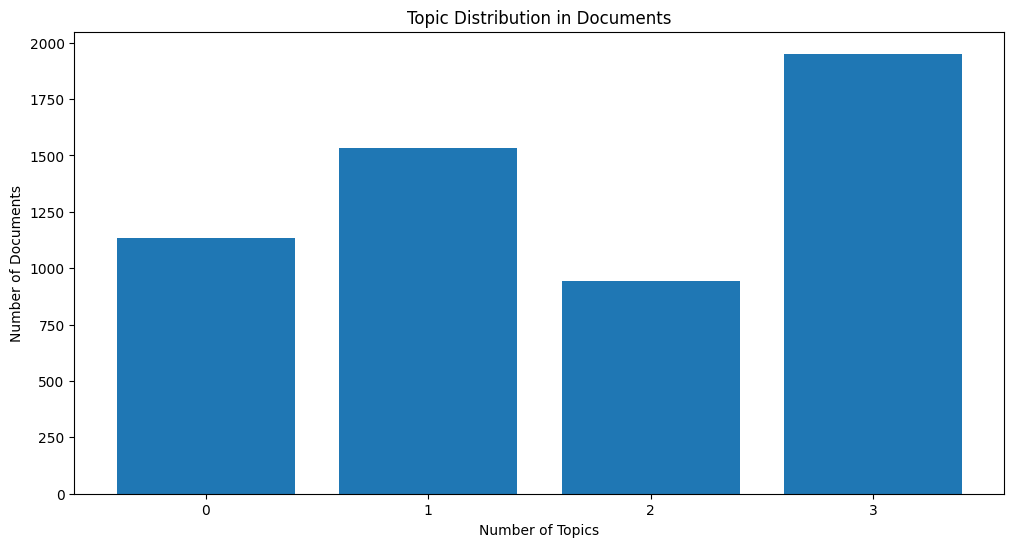

In [ ]:
# Extract topic probabilities for the best model
topic_probabilities = [best_model.get_document_topics(doc) for doc in corpus]

# Get the highest probabilities for each document
max_topic_probabilities = [max(prob, key=lambda x: x[1]) for prob in topic_probabilities]

# Calculate the frequency distribution of topics
topic_distribution = [item[0] for item in max_topic_probabilities]

# Count how many times each topic is assigned as the main topic for the documents
topic_counts = Counter(topic_distribution)

# Create a bar chart to visualize the distribution of topics in documents
plt.figure(figsize=(12, 6))
plt.bar(topic_counts.keys(), topic_counts.values())
plt.xlabel('Number of Topics')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution in Documents')
plt.xticks(range(best_num_topics))
plt.show()


In [ ]:
# Enable pyLDAvis visualization in the notebook
pyLDAvis.enable_notebook()

# Prepare data for pyLDAvis
LDAvis_data_filepath = '/content/ldavis_prepared_' + str(best_num_topics)

# If the file doesn't exist, calculate the data and save it to a file
if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = gensimvis.prepare(best_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # If the file exists, load the data from it
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

# Save the visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, '/content/ldavis_prepared_' + str(best_num_topics) + '.html')

# Display the interactive visualization
pyLDAvis.display(LDAvis_prepared, template_type='general')

# Return the pyLDAvis data
LDAvis_prepared


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.265673  0.073951       1        1  29.360807
1     -0.097233 -0.117076       2        1  27.544798
2      0.180464 -0.199822       3        1  24.464883
0      0.182442  0.242948       4        1  18.629512, topic_info=       Term         Freq        Total Category  logprob  loglift
10      you  1164.000000  1164.000000  Default  30.0000  30.0000
173      gt   315.000000   315.000000  Default  29.0000  29.0000
175      lt   313.000000   313.000000  Default  28.0000  28.0000
19     text   374.000000   374.000000  Default  27.0000  27.0000
49     call   608.000000   608.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
79     cash    48.078974    89.763316   Topic4  -4.7969   1.0561
422  number    45.985097   105.263889   Topic4  -4.8415   0.8523
72    today    48.909765   187.905176   Topic4  -4.7798   0.3345
20       to    42.929860   625.693885   Topic4  -4.9102  -0.9989
212    come    40.790206   221.934784   Topic4  -4.9613  -0.0135

[234 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
30        2  0.011405     1
30        3  0.986555     1
30        4  0.005703     1
76        3  0.971970   100
221       4  0.992603  1000
...     ...       ...   ...
10        4  0.006010   you
115       1  0.075344  your
115       2  0.259806  your
115       3  0.662504  your
159       2  0.974798   yup

[304 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


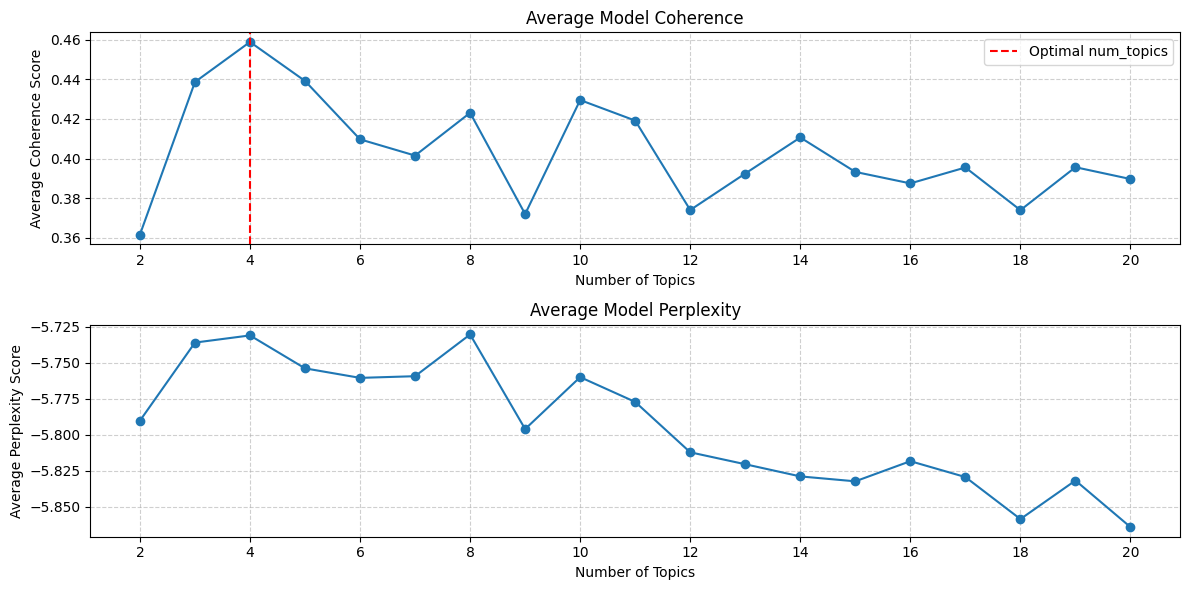

In [ ]:
# Extract coherence and perplexity values
coherence_values = [x[0] for x in a]
perplexity_values = [x[1] for x in a]

# Create a list of topic numbers from 2 to 20
num_topics = list(range(2, 21))

# Create empty dictionaries to store the averages
coherence_avg = {}
perplexity_avg = {}

# Calculate averages for each number of topics
for n_components in num_topics:
    coh_sum = 0
    perplexity_sum = 0
    count = 0

    for i in range(len(a)):
        if num_topics[i // num_runs] == n_components:
            coh_sum += coherence_values[i]
            perplexity_sum += perplexity_values[i]
            count += 1

    coherence_avg[n_components] = coh_sum / count
    perplexity_avg[n_components] = perplexity_sum / count

# Create the plot
plt.figure(figsize=(12, 6))

# Subplot for average coherence
plt.subplot(2, 1, 1)
plt.plot(num_topics, [coherence_avg[n] for n in num_topics], marker='o', linestyle='-')
plt.title("Average Model Coherence")
plt.xlabel("Number of Topics")
plt.ylabel("Average Coherence Score")

# Set x-axis ticks to display even numbers from 2 to 20
plt.xticks(range(2, 21, 2))
plt.grid(True, linestyle='--', alpha=0.6)

# Add a dashed vertical line for the optimal num_topics only in the first subplot
plt.axvline(x=best_num_topics, color='red', linestyle='--', label='Optimal num_topics')
plt.legend()

# Subplot for average perplexity
plt.subplot(2, 1, 2)
plt.plot(num_topics, [perplexity_avg[n] for n in num_topics], marker='o', linestyle='-')
plt.title("Average Model Perplexity")
plt.xlabel("Number of Topics")
plt.ylabel("Average Perplexity Score")

# Set x-axis ticks to display even numbers from 2 to 20
plt.xticks(range(2, 21, 2))
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Find the best number of topics based on the highest coherence score
best_topic_coherence = max(coherence_avg.values())
best_num_topics = max(coherence_avg, key=coherence_avg.get)
best_model_perplexity = perplexity_avg[best_num_topics]
